In [1]:
import pandas as pd

In [2]:
file_path = "eu_bdt-ud-dev.conllu"  # Replace with the actual path to your file

lines = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line and not line.startswith('#'):  # Filter out empty lines and comments
            lines.append(line.split('\t'))

In [3]:
column_names = ['id', 'form', 'lemma', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc']
df = pd.DataFrame(lines, columns=column_names)

In [4]:
df = df.replace({'_': pd.NA})  # Replace '_' with Na

In [5]:
df['feats'] = df['feats'].fillna('')

In [6]:
threshold = 0.8 
df = df.dropna(thresh=len(df) * (1 - threshold), axis=1) 
print("Columns remaining:", df.columns)

Columns remaining: Index(['id', 'form', 'lemma', 'upos', 'feats', 'head', 'deprel'], dtype='object')


In [7]:
lemmas_of_interest = ['izan', 'ukan']
upos_of_interest = ['VERB', 'AUX']

df_reduced = df[df['lemma'].isin(lemmas_of_interest) & df['upos'].isin(upos_of_interest)].copy()

print(f"Shape of the reduced DataFrame: {df_reduced.shape}")
print(df_reduced.head())

Shape of the reduced DataFrame: (1707, 7)
    id  form lemma  upos                                              feats  \
7    8  izan  izan  VERB                          Aspect=Perf|VerbForm=Part   
15   6    da  izan   AUX  Mood=Ind|Number[abs]=Sing|Person[abs]=3|VerbFo...   
29  12   zen  izan   AUX  Mood=Ind|Number[abs]=Sing|Person[abs]=3|VerbFo...   
34   4   den  izan   AUX  Mood=Ind|Number[abs]=Sing|Person[abs]=3|VerbFo...   
39   2  izan  izan  VERB                          Aspect=Perf|VerbForm=Part   

   head deprel  
7     0   root  
15    5    aux  
29   11    aux  
34    3    aux  
39    4    acl  


In [8]:
import re
from collections import Counter

all_features = []
for feats_str in df_reduced['feats']:
    if isinstance(feats_str, str):  # Ensure we are working with a string
        features = re.findall(r'([^|=]+)=[^|]*', feats_str)
        all_features.extend(features)

feature_counts = Counter(all_features)
unique_features = list(feature_counts.keys())

print("Unique morphological features found:")
print(unique_features)
print("\nFeature counts:")
print(feature_counts)

Unique morphological features found:
['Aspect', 'VerbForm', 'Mood', 'Number[abs]', 'Person[abs]', 'Number[erg]', 'Person[erg]', 'Number[dat]', 'Person[dat]', 'Polarity', 'Case', 'Definite', 'Gender', 'Polite', 'Number', 'Gender[erg]', 'Polite[erg]']

Feature counts:
Counter({'VerbForm': 1707, 'Mood': 1321, 'Number[abs]': 1321, 'Person[abs]': 1321, 'Aspect': 855, 'Number[erg]': 247, 'Person[erg]': 247, 'Case': 74, 'Number[dat]': 67, 'Person[dat]': 67, 'Definite': 43, 'Number': 31, 'Polarity': 17, 'Gender': 9, 'Polite': 9, 'Gender[erg]': 1, 'Polite[erg]': 1})


In [9]:
infrequent_features = {feature for feature, count in feature_counts.items() if count < 50}
print("\nInfrequent features to discard:", infrequent_features)

def filter_by_frequent_features(row):
    if isinstance(row['feats'], str):
        features_in_row = set(re.findall(r'([^|=]+)=[^|]*', row['feats']))
        return not (features_in_row & infrequent_features)
    return True  # Keep rows where 'feats' is NaN or empty

df_filtered = df_reduced[df_reduced.apply(filter_by_frequent_features, axis=1)].copy()

print(f"\nShape of the DataFrame after filtering infrequent features: {df_filtered.shape}")
print(df_filtered.head())


Infrequent features to discard: {'Polarity', 'Polite[erg]', 'Gender[erg]', 'Gender', 'Definite', 'Number', 'Polite'}

Shape of the DataFrame after filtering infrequent features: (1639, 7)
    id  form lemma  upos                                              feats  \
7    8  izan  izan  VERB                          Aspect=Perf|VerbForm=Part   
15   6    da  izan   AUX  Mood=Ind|Number[abs]=Sing|Person[abs]=3|VerbFo...   
29  12   zen  izan   AUX  Mood=Ind|Number[abs]=Sing|Person[abs]=3|VerbFo...   
34   4   den  izan   AUX  Mood=Ind|Number[abs]=Sing|Person[abs]=3|VerbFo...   
39   2  izan  izan  VERB                          Aspect=Perf|VerbForm=Part   

   head deprel  
7     0   root  
15    5    aux  
29   11    aux  
34    3    aux  
39    4    acl  


In [10]:
# cell10
for feature_name in unique_features:
    pattern = rf'{re.escape(feature_name)}=([^|]*)'
    df_filtered[feature_name] = df_filtered['feats'].str.extract(pattern)

print(f"Shape of DataFrame after extracting features: {df_filtered.shape}")
print(df_filtered.head())

Shape of DataFrame after extracting features: (1639, 24)
    id  form lemma  upos                                              feats  \
7    8  izan  izan  VERB                          Aspect=Perf|VerbForm=Part   
15   6    da  izan   AUX  Mood=Ind|Number[abs]=Sing|Person[abs]=3|VerbFo...   
29  12   zen  izan   AUX  Mood=Ind|Number[abs]=Sing|Person[abs]=3|VerbFo...   
34   4   den  izan   AUX  Mood=Ind|Number[abs]=Sing|Person[abs]=3|VerbFo...   
39   2  izan  izan  VERB                          Aspect=Perf|VerbForm=Part   

   head deprel Aspect VerbForm Mood  ... Number[dat] Person[dat] Polarity  \
7     0   root   Perf     Part  NaN  ...         NaN         NaN      NaN   
15    5    aux    NaN      Fin  Ind  ...         NaN         NaN      NaN   
29   11    aux    NaN      Fin  Ind  ...         NaN         NaN      NaN   
34    3    aux    NaN      Fin  Ind  ...         NaN         NaN      NaN   
39    4    acl   Perf     Part  NaN  ...         NaN         NaN      NaN   

   Ca

In [11]:
# cell11
def combine_agreement(row, argument):
    number = row.get(f'Number[{argument}]')
    person = row.get(f'Person[{argument}]')
    if pd.notna(number) and pd.notna(person):
        return f"{person}{number[:2].lower()}"  # e.g., 3sg, 1pl
    return pd.NA

df_filtered['Abs'] = df_filtered.apply(lambda row: combine_agreement(row, 'abs'), axis=1)
df_filtered['Erg'] = df_filtered.apply(lambda row: combine_agreement(row, 'erg'), axis=1)
df_filtered['Dat'] = df_filtered.apply(lambda row: combine_agreement(row, 'dat'), axis=1)

# Drop the original Number and Person agreement columns
cols_to_drop = [col for col in df_filtered.columns if col.startswith('Number[') or col.startswith('Person[')]
df_filtered = df_filtered.drop(columns=cols_to_drop, errors='ignore')

print(df_filtered[['form', 'lemma', 'upos', 'Abs', 'Erg', 'Dat']].head())

    form lemma  upos   Abs   Erg   Dat
7   izan  izan  VERB  <NA>  <NA>  <NA>
15    da  izan   AUX   3si  <NA>  <NA>
29   zen  izan   AUX   3si  <NA>  <NA>
34   den  izan   AUX   3si  <NA>  <NA>
39  izan  izan  VERB  <NA>  <NA>  <NA>


In [12]:
# cell12
cols_to_categorical = ['lemma', 'upos', 'deprel', 'Abs', 'Erg', 'Dat']

for col in cols_to_categorical:
    if col in df_filtered.columns:
        df_filtered[col] = df_filtered[col].astype('category')

print(df_filtered.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1639 entries, 7 to 24091
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           1639 non-null   object  
 1   form         1639 non-null   object  
 2   lemma        1639 non-null   category
 3   upos         1639 non-null   category
 4   feats        1639 non-null   object  
 5   head         1639 non-null   object  
 6   deprel       1639 non-null   category
 7   Aspect       825 non-null    object  
 8   VerbForm     1639 non-null   object  
 9   Mood         1278 non-null   object  
 10  Polarity     0 non-null      object  
 11  Case         31 non-null     object  
 12  Definite     0 non-null      object  
 13  Gender       0 non-null      object  
 14  Polite       0 non-null      object  
 15  Number       0 non-null      object  
 16  Gender[erg]  0 non-null      object  
 17  Polite[erg]  0 non-null      object  
 18  Abs          1278 non-null   cat

In [13]:
# cell13
feature_columns = [col for col in df_filtered.columns if col not in ['id', 'form', 'lemma', 'upos', 'xpos', 'head', 'deprel', 'deps', 'misc', 'feats']]

form_frequency = df_filtered.groupby(['form'] + feature_columns).size().reset_index(name='count')

print("Frequency of each form with its features:")
print(form_frequency.head())
print(f"\nShape of the form frequency DataFrame: {form_frequency.shape}")

Frequency of each form with its features:
Empty DataFrame
Columns: [form, Aspect, VerbForm, Mood, Polarity, Case, Definite, Gender, Polite, Number, Gender[erg], Polite[erg], Abs, Erg, Dat, count]
Index: []

Shape of the form frequency DataFrame: (0, 16)


/tmp/ipykernel_20925/2568356902.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  form_frequency = df_filtered.groupby(['form'] + feature_columns).size().reset_index(name='count')


/tmp/ipykernel_20925/1637451222.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_shares_sorted.index, y=feature_shares_sorted.values, palette="viridis")


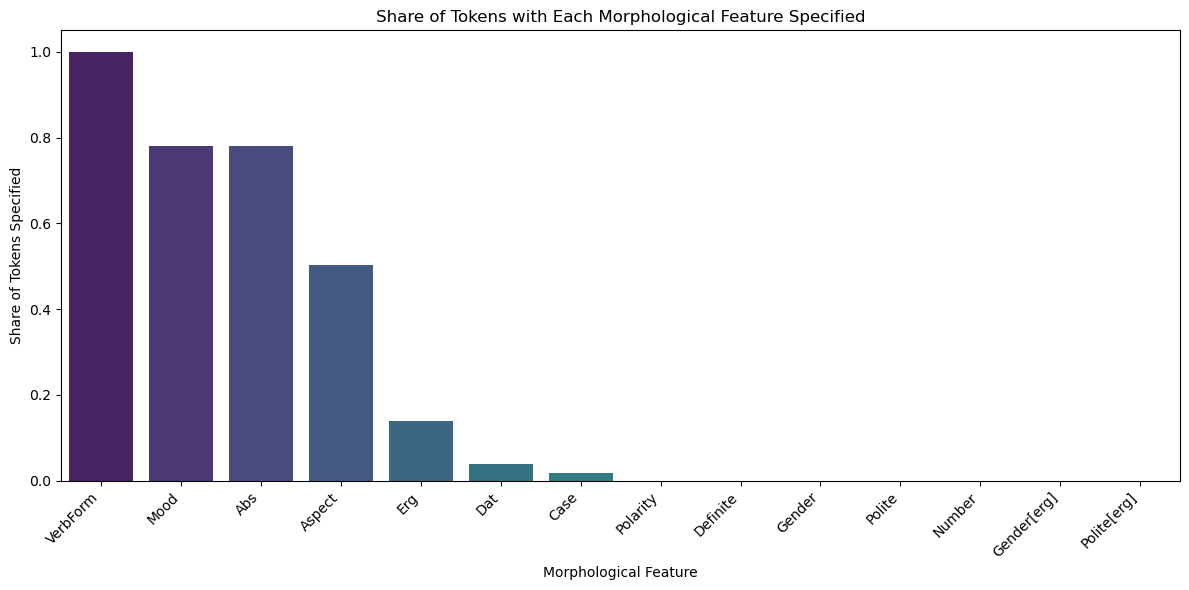

In [14]:
# cell14
import matplotlib.pyplot as plt
import seaborn as sns

feature_presence = df_filtered[feature_columns].notna().sum()
total_tokens = len(df_filtered)
feature_shares = feature_presence / total_tokens

# Sort features by their share for better visualization
feature_shares_sorted = feature_shares.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_shares_sorted.index, y=feature_shares_sorted.values, palette="viridis")
plt.ylabel("Share of Tokens Specified")
plt.xlabel("Morphological Feature")
plt.title("Share of Tokens with Each Morphological Feature Specified")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

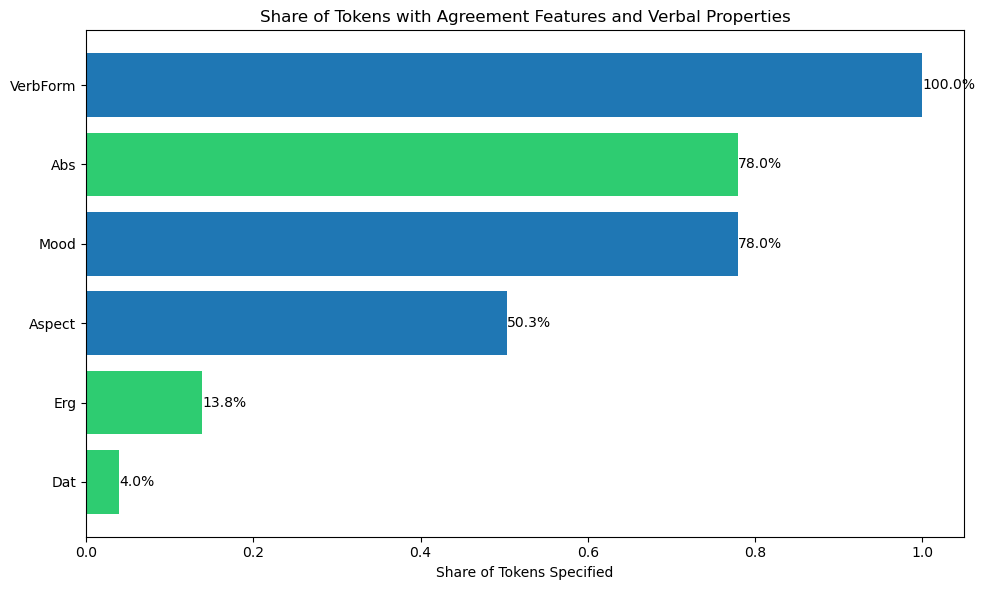

In [15]:
#cell 15
# Select the relevant features for verbal agreement and key verbal properties
relevant_features = ['VerbForm', 'Mood', 'Aspect', 'Abs', 'Erg', 'Dat']
feature_presence_relevant = df_filtered[relevant_features].notna().sum()
feature_shares_relevant = feature_presence_relevant / len(df_filtered)

# Sort by their share
feature_shares_sorted = feature_shares_relevant.sort_values(ascending=True)

# Create bar plot with a different color scheme for agreement 
colors = ['#1f77b4' if f not in ['Abs', 'Erg', 'Dat'] else '#2ecc71' for f in feature_shares_sorted.index]

plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(feature_shares_sorted)), feature_shares_sorted.values, color=colors)
plt.yticks(range(len(feature_shares_sorted)), feature_shares_sorted.index)
plt.xlabel('Share of Tokens Specified')
plt.title('Share of Tokens with Agreement Features and Verbal Properties')

# Add percentage labels on the bars
for i, v in enumerate(feature_shares_sorted.values):
    plt.text(v, i, f'{v:.1%}', va='center')

plt.tight_layout()
plt.show()